In [2]:
%load_ext autoreload
%autoreload 2


import torch
from torch import nn
from torch.utils import data
import xarray as xr
import cfr
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

## Data preprocessing

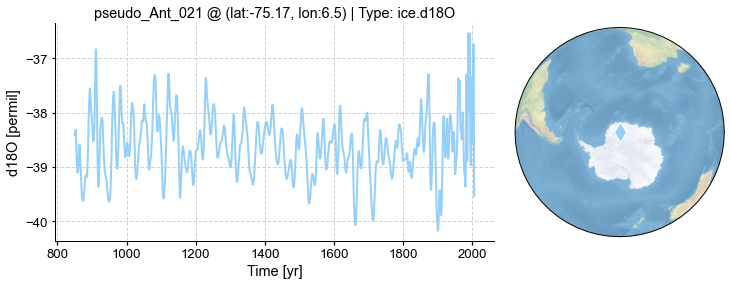

In [3]:
pdb = pd.read_pickle('./data/pseudoPAGES2k/pseudo.ice.d18O.pkl')
fig, ax = pdb.records['pseudo_Ant_021'].plot()

In [4]:
dirpath = './data'

tas = cfr.ClimateField().load_nc(os.path.join(dirpath, 'tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
pr = cfr.ClimateField().load_nc(os.path.join(dirpath, 'pr_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
psl = cfr.ClimateField().load_nc(os.path.join(dirpath, 'psl_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))
d18O = cfr.ClimateField().load_nc(os.path.join(dirpath, 'd18O_sfc_Amon_iCESM_past1000historical_085001-200512.nc'))

In [6]:
tas_ann = tas.annualize()
pr_ann = pr.annualize()
psl_ann = psl.annualize()
d18O_ann = d18O.annualize()

In [19]:
pobj = pdb.records['pseudo_Ant_021']
pobj.del_clim()
pobj.get_clim(tas_ann, tag='obs')
pobj.get_clim(pr_ann, tag='obs')
pobj.get_clim(psl_ann, tag='obs')
pobj.get_clim(d18O_ann, tag='obs')

In [8]:
features, scaler_f = cfr.ml.mk_tensors([
    pobj.clim['obs_tas'].da.values,
    pobj.clim['obs_pr'].da.values,
    pobj.clim['obs_psl'].da.values,
    pobj.clim['obs_d18O'].da.values,
])
features.shape

torch.Size([1156, 4])

In [9]:
labels, scaler_l = cfr.ml.mk_tensors([pobj.value])
labels.shape

torch.Size([1156, 1])

In [10]:
features_exp = cfr.ml.sliding_tensor(features)
labels_exp = cfr.ml.sliding_tensor(labels)
print(features_exp.shape)
print(labels_exp.shape)

torch.Size([1154, 3, 4])
torch.Size([1154, 3, 1])


In [11]:
data_dict = cfr.ml.split_data(features_exp, labels_exp, batch_size=5)
train_loader = data_dict['train_loader']
valid_f, valid_l = data_dict['valid_f'], data_dict['valid_l']
test_f, test_l = data_dict['test_f'], data_dict['test_l']

## GRU

In [ ]:
ne = 50
lr = 0.001

res = cfr.ml.train_model(
    train_loader, valid_f, valid_l, lr=lr, model_type='GRU',
    max_epochs=ne, save_path=f'./data/model/optim_lstm_{pobj.pid}.pt',
)

device: cpu
Starting training of "GRU" model.
Epoch 1/50 - Train loss: 0.025373154284813834, Valid loss: 0.015682127326726913
Epoch 2/50 - Train loss: 0.018104586541058794, Valid loss: 0.013753541745245457
Epoch 3/50 - Train loss: 0.018021178559190932, Valid loss: 0.0169590562582016
Epoch 4/50 - Train loss: 0.01685372466032488, Valid loss: 0.01637062430381775
Epoch 5/50 - Train loss: 0.017550638367327443, Valid loss: 0.015637576580047607
Epoch 6/50 - Train loss: 0.016841008205580918, Valid loss: 0.018976451829075813
Epoch 7/50 - Train loss: 0.016299053606496233, Valid loss: 0.01462810579687357
Epoch 8/50 - Train loss: 0.016409549453005573, Valid loss: 0.01407813373953104
Epoch 9/50 - Train loss: 0.016219038005067927, Valid loss: 0.013051552698016167
Epoch 10/50 - Train loss: 0.016161815854265234, Valid loss: 0.013200531713664532
Epoch 11/50 - Train loss: 0.015602412608290173, Valid loss: 0.013909805566072464
Epoch 12/50 - Train loss: 0.015715419913750087, Valid loss: 0.0122834928333759

In [12]:
model, train_loss, valid_loss, optim_epoch = torch.load('./data/model/optim_lstm_pseudo_Ant_021.pt')

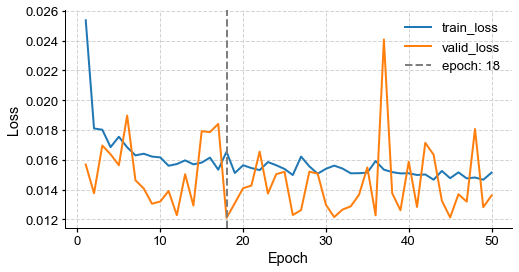

In [13]:
fig, ax = cfr.visual.plot_ml_loss(train_loss, valid_loss, optim_epoch=optim_epoch)

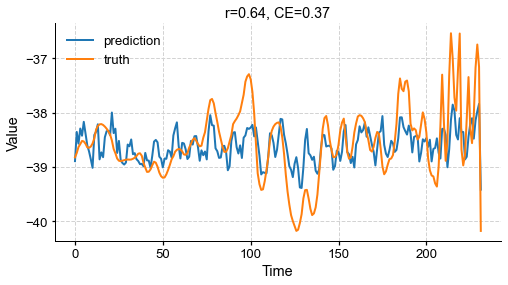

In [14]:
res_dict = cfr.ml.eval_model(model, test_f, test_l, scaler_l)
fig, ax = cfr.visual.plot_ml_predict(res_dict)

## Linear regression

In [23]:
ne = 50
lr = 0.001

res = cfr.ml.train_model(
    train_loader, valid_f, valid_l, lr=lr, model_type='Linear',
    max_epochs=ne, save_path=f'./data/model/optim_linreg_{pobj.pid}.pt',
)

device: cpu
Starting training of "Linear" model.
Epoch 1/50 - Train loss: 0.05200845635482582, Valid loss: 0.02217870019376278
Epoch 2/50 - Train loss: 0.02520892946926904, Valid loss: 0.02401781640946865
Epoch 3/50 - Train loss: 0.02452760663193961, Valid loss: 0.02334022894501686
Epoch 4/50 - Train loss: 0.02412885205273557, Valid loss: 0.02245911955833435
Epoch 5/50 - Train loss: 0.0234223105480719, Valid loss: 0.022795015946030617
Epoch 6/50 - Train loss: 0.02305720105220604, Valid loss: 0.022142376750707626
Epoch 7/50 - Train loss: 0.022803768141033208, Valid loss: 0.02153264731168747
Epoch 8/50 - Train loss: 0.022207156445011093, Valid loss: 0.023224176838994026
Epoch 9/50 - Train loss: 0.02212797462825488, Valid loss: 0.021617446094751358
Epoch 10/50 - Train loss: 0.021469072426966242, Valid loss: 0.019485944882035255
Epoch 11/50 - Train loss: 0.021428218693472445, Valid loss: 0.02059272490441799
Epoch 12/50 - Train loss: 0.02099828439447489, Valid loss: 0.019240735098719597
Epo

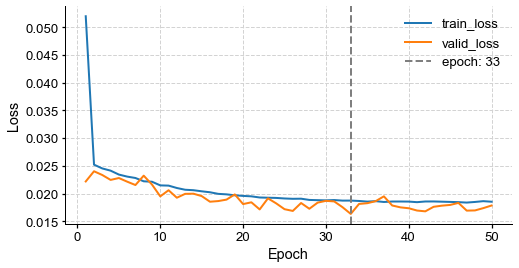

In [26]:
train_loss, valid_loss, optim_epoch = res['train_loss'], res['valid_loss'], res['optim_epoch']
fig, ax = cfr.visual.plot_ml_loss(train_loss, valid_loss, optim_epoch=optim_epoch)

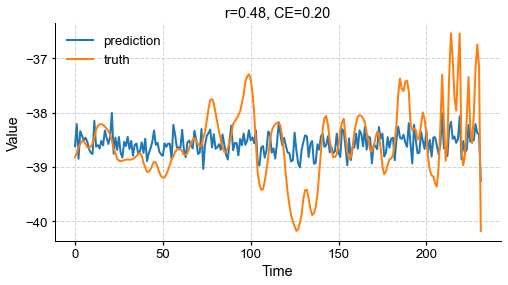

In [29]:
res_dict = cfr.ml.eval_model(res['optim_model'], test_f, test_l, scaler_l)
fig, ax = cfr.visual.plot_ml_predict(res_dict)